## Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

Preparing the Data

In [2]:
# preparing our data
raw_prices = pd.read_csv("https://open-data.s3.filebase.com/assetalloc.csv", sep=';', parse_dates=True, index_col='Dates', dayfirst=True)
df = raw_prices.sort_values(by='Dates')
df["target"] = df["SP500"].pct_change().shift(-1)
df["target"] = np.where(df["target"]>0,1,0)
df.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB,target
Dates,,,,,,,,,,,,,,,,,,
1989-02-01,2039.7,875.47,297.09,392.50,99.081,99.039,99.572,100.000,100.031,100.345,101.080,101.936,154.38,117.50,1636.57,133.584,286.67,0
1989-02-02,2043.4,878.08,296.84,392.00,98.898,99.117,99.278,99.692,100.000,100.314,101.017,101.905,154.94,117.69,1642.94,135.052,287.03,1
1989-02-03,2069.9,884.09,296.97,388.75,98.907,99.002,99.145,99.178,99.812,100.062,100.921,101.718,155.69,118.62,1659.11,137.134,285.63,0
1989-02-06,2044.3,885.49,296.04,388.00,98.484,98.502,98.510,97.739,99.812,100.062,100.794,101.468,155.58,118.89,1656.86,137.037,284.69,1
1989-02-07,2072.8,883.82,299.63,392.75,98.438,98.312,98.292,97.688,99.906,100.251,101.144,102.092,156.84,118.28,1662.76,136.914,284.21,0


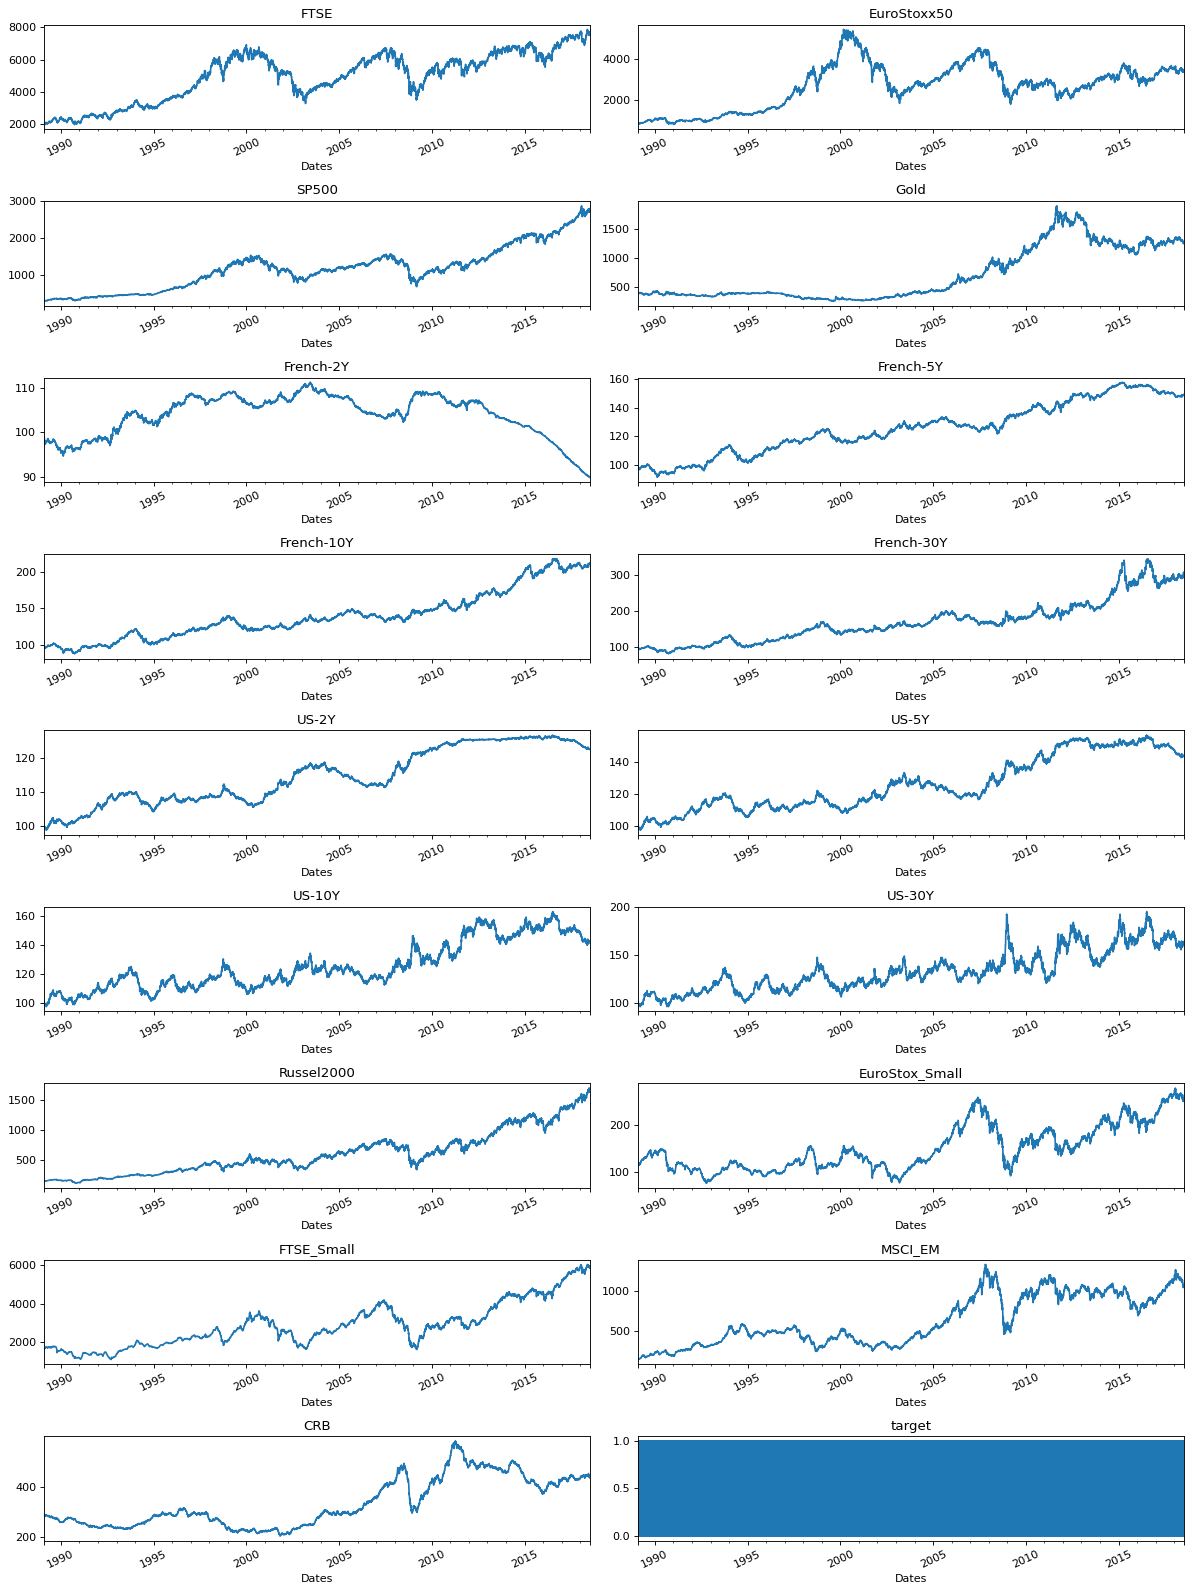

In [3]:
#date_time_key = df.index_col

def show_raw_visualization(data):
    data = data.reset_index()
    time_data = data["Dates"]
    fig, axes = plt.subplots(
        nrows=9, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(data.columns)-1):
        key = data.columns[i+1]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title = key,
            rot=25,
        )
    plt.tight_layout()

show_raw_visualization(df)

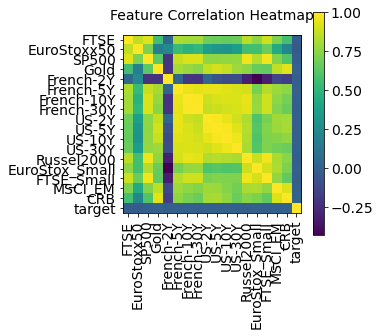

In [4]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

### Extracting

Moved Extracting feature engineering part above Train Test split so that the top part of the features for test data are not lost.

In [5]:
# Name: Annualized volatility in returns
# Description: We are developing an annualized volatility measure for all asset returns, which is a good measure of market turbulence

def vola(df):
    volatility = df.iloc[:,0:17].pct_change().rolling(window=252).std()*(252**0.5)
    new_names = [(i,i+'_vol') for i in df.iloc[:,0:17].columns.values]   
    volatility.rename(columns = dict(new_names), inplace=True)
    df = pd.concat((df, volatility), axis=1)
    return df

df = vola(df)

In [6]:
!pip install ta
import ta
from ta.trend import MACD
from ta.momentum import RSIIndicator

In [7]:
# Name: Moving Average Convergence Divergence
# Description: MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price

def ma(df, columns):
    for col in columns:
        indicator_macd = MACD(df[col], 26, 12, 9)
        ma = indicator_macd.macd_signal().to_frame(name = col+'_macd')
        df = pd.concat((df, ma), axis=1)
    return df

df = ma(df, ['SP500', 'Russel2000'])


In [8]:
# Name: Relative Strength Index
# Description: RSI is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought 
# or oversold conditions in the price of a stock or other asset

def rsi(df, columns):
    for col in columns:
        indicator_rsi = RSIIndicator(df[col], 20)
        ma = indicator_rsi.rsi().to_frame(name = col+'_rsi')
        df = pd.concat((df, ma), axis=1)
    return df

df = rsi(df, ['SP500', 'Russel2000'])

In [9]:
# Name: Rolling mean
# Description: Rolling mean helps to smooth out the price data over a specified period of time by creating a constantly updated average price

def rolling_mean(df):
    roll_mean = df[["FTSE","FTSE_Small"]].rolling(window=7).mean().add_suffix('_rolling_mean')
    df = pd.concat((df, roll_mean), axis=1)
    return df

df = rolling_mean(df)


### Train Test Split

In [10]:
from sklearn.model_selection import train_test_split
y = df.pop("target")
X = df.copy()

X_train_val = X[X.index.astype(str)<'2018-01-01']
y_train_val = y[X_train_val.index]
y_train_val = pd.DataFrame(y_train_val)
X_test = X[~X.index.isin(X_train_val.index)]
y_test = y[X_test.index]
y_test = pd.DataFrame(y_test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Transforming

In [11]:
# Name: Logarithmic return of FTSE 
# Description: Developing the logarithmic return feature for use within linear models that make normality assumptions. 

def log_values(df):
    df["FTSE_log"] = np.log1p(df["FTSE"].pct_change())
    return df

X_train_val = log_values(X_train_val)
X_test = log_values(X_test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [12]:
# Name: Savgol filter smooting 
# Description: Smoothing the data to increase the precision of the data without distorting the signal tendency.

from scipy.signal import savgol_filter

def smoothing(df):
    df["EuroStox_Small_smooth"] = savgol_filter(df['EuroStox_Small'], 51, 3)
    df["EuroStoxx50_smooth"] = savgol_filter(df['EuroStoxx50'], 51, 3)
    return df

X_train_val = smoothing(X_train_val)
X_test = smoothing(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [13]:
# Name: Random walk filter 
# Description: Used CF Filter to deal with the periodicity of the business cycle.

import statsmodels
from statsmodels.tsa.filters.cf_filter import cffilter

def filtering(df):
    df['crb_cycles'], trend = cffilter(df['CRB'], 2000)
    return df

X_train_val = filtering(X_train_val)
X_test = filtering(X_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [14]:
# Name: Min Max Scaling
# Description: Transform features by scaling and translating each feature individually such that it is in the given range on the training set

from sklearn.preprocessing import MinMaxScaler

def mm_scale(X_train, X_test):
    mm = MinMaxScaler()
    new_names = [(i+'_minmax') for i in X_train.iloc[:,0:17].columns.values]   

    X_train_m = pd.DataFrame(mm.fit_transform(X_train.iloc[:,0:17]), columns = new_names, index = X_train.index)
    X_test_m = pd.DataFrame(mm.fit_transform(X_test.iloc[:,0:17]), columns = new_names, index = X_test.index)

    X_train = pd.concat((X_train, X_train_m), axis=1)
    X_test = pd.concat((X_test, X_test_m), axis=1)

    return X_train, X_test

X_train_val, X_test = mm_scale(X_train_val, X_test)


### Interacting

In [15]:
# Name: Ratio of Gold return to 10Y treasury
# Desciption: Both gold and treasuries are safe-haven assets and descrepency in their ratio could be a sign of some marco-economic event.

def gold_to_yield(df):
    teny_returns = df["US-10Y"]
    gold_returns = df["Gold"].pct_change()
    df["gold_r__div__teny_r"] = gold_returns/teny_returns
    return df

X_train_val = gold_to_yield(X_train_val)
X_test = gold_to_yield(X_test)

In [16]:
# Name: Yield Curve spread
# Desciption: The difference between 10Y and 2Y yields provides the spread in the yields. When this difference becomes negative, it is an indication of 
# upcoming recession.

def diff_10y_2y(df):
    df["diff_10y_2y"] = df['US-10Y'] - df['US-5Y']
    return df

X_train_val = diff_10y_2y(X_train_val)
X_test = diff_10y_2y(X_test)

In [17]:
# Name: Correlation of Gold to Emerging Markets
# Desciption: Gold is a safe haven asset while Emerging Market stocks are most risky ones. The correlation between them can tell the emotions in the market. 

def corr(df):
    df['corr_Gold_EM'] = df['Gold'].rolling(7).corr(df['MSCI_EM'])
    return df

X_train_val = corr(X_train_val)
X_test = corr(X_test)

In [18]:
!pip install gplearn
from gplearn.genetic import SymbolicTransformer

In [19]:
# Name: Genetic Feature Engineering
# Desciption: Genetic Feature Engineering is a forward looking interaction that will learn patterns from the training data as they relate to the label, 
# and will then apply these learned patterns to the test data.

def genetic_feat(X_train, y_train, X_test, num_gen=20, num_comp=2):
    function_set = ['add', 'sub', 'mul', 'div',
                  'sqrt', 'log', 'abs', 'neg', 'inv', 'tan']

    gp = SymbolicTransformer(generations=num_gen, population_size=200,
                             hall_of_fame=100, n_components=num_comp,
                             function_set=function_set,
                             parsimony_coefficient=0.0005,
                             max_samples=0.9, verbose=1,
                             random_state=0, n_jobs=6)

    gen_feats_train = pd.DataFrame(gp.fit_transform(X_train.iloc[:,0:17], y_train), columns = ['gen_feats_1','gen_feats_2'], index = X_train.index)
    gen_feats_test = pd.DataFrame(gp.transform(X_test.iloc[:,0:17]), columns = ['gen_feats_1','gen_feats_2'], index = X_test.index)
    
    X_train = pd.concat((X_train, gen_feats_train), axis=1)
    X_test = pd.concat((X_test, gen_feats_test), axis=1)
    
    return X_train, X_test 

X_train_val, X_test = genetic_feat(X_train_val, y_train_val, X_test) 

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   0     8.31       0.00924678        3        0.0390885        0.0314409      1.04m
   1     5.38        0.0217046        5        0.0404122        0.0604821     23.47s
   2     3.51        0.0250635        3        0.0401654        0.0422327     25.76s
   3     3.00         0.027029        4        0.0418255       0.00779273     25.59s
   4     3.42        0.0285876        4        0.0478192        0.0670179     24.26s
   5     3.85        0.0269826        4        0.0505299        0.0788278     21.98s
   6     3.96        0.0253172        4        0.0453055        0.0419538     27.77s
   7     3.93        0.0262889        4        0.0468777        0.0506545     23.50s
   8     3.96        0.0259309        4         0.045955         0.044679     23.01s
   9     4.16        0.0247651        4        0.0446158        0.0310625     18.99s
  10     3.88        0.0277363        4        0.0473973        0.0568923     17.89s
  11     4.10        0.0253198        4        0.0464162        0

### Mapping

In [20]:
# Name: First prinicipal component of all of the assets returns
# Description: For stocks the first component resmbles the return of the market, 
# for multiple asset classes it could resemble a 'universal' asset class

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_first(X_train, X_test):
    sc = StandardScaler()
    #X_train_s = pd.DataFrame(sc.fit_transform(X_train.fillna(0))) 
    #X_test_s = pd.DataFrame(sc.transform(X_test.fillna(0))) 
    X_train_s = sc.fit_transform(X_train.iloc[:,0:17].fillna(0))
    X_test_s = sc.transform(X_test.iloc[:,0:17].fillna(0))

    pca = PCA(1)
    X_train["first_prinicipal"] = pca.fit_transform(X_train_s)
    X_test["first_prinicipal"] = pca.transform(X_test_s)
    return X_train, X_test

X_train_val, X_test = pca_first(X_train_val, X_test)

In [21]:
## Name : Canonical Correlation Analysis of FTSE and SP500
## Description : CCA is used to find the Cointegration factors between two series. We expect FTSE and SP500 to be cointegrating 
## and thus help in our predictions.

from sklearn.cross_decomposition import CCA

def cca_first(X_train, X_test):
    cca = CCA(2)
    X_train["FTSE_cca"],X_train["SP500_cca"] = cca.fit_transform(X_train[["FTSE"]],X_train["SP500"])
    X_test["FTSE_cca"],X_test["SP500_cca"] = cca.transform(X_test[["FTSE"]],X_test["SP500"])
    return X_train, X_test

X_train_val, X_test = cca_first(X_train_val, X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(2) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,


In [22]:
# Name: Non-Negative Matrix Factorization of US Treasury yields
# Description: NMF takes in non-negative inputs and can be used for dimensionality reduction, source separation or topic extraction. 
# Yields are expected to be positive only.

from sklearn.decomposition import NMF

def nmf_first(X_train, X_test):
    nmf = NMF(1)
    X_train["US_Treasury_nmf"] = nmf.fit_transform(X_train[["US-2Y","US-5Y","US-10Y","US-30Y"]].fillna(0))
    X_test["US_Treasury_nmf"] = nmf.transform(X_test[["US-2Y","US-5Y","US-10Y","US-30Y"]].fillna(0))
    return X_train, X_test

X_train_val, X_test = nmf_first(X_train_val, X_test)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [23]:
# Name: Dimensionality reduction using truncated SVD of French Treasury yields
# Description: TruncatedSVD performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). 
# Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. \
# This means it can work with sparse matrices efficiently.

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

def svd(X_train, X_test):
    sc = StandardScaler()
    X_train_s = sc.fit_transform(X_train[["French-2Y","French-5Y","French-10Y","French-30Y"]].fillna(0))
    X_test_s = sc.transform(X_test[["French-2Y","French-5Y","French-10Y","French-30Y"]].fillna(0))

    svd = TruncatedSVD(1, random_state = 2)
    X_train["French_Treasury_nmf"] = svd.fit_transform(X_train_s)
    X_test["French_Treasury_nmf"] = svd.transform(X_test_s)
    return X_train, X_test

X_train_val, X_test = svd(X_train_val, X_test)

In [24]:
X_train_val = X_train_val.dropna()
X_test = X_test.dropna()

## Deep Learning Binary Classification

In [44]:
## Implement Here
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(1087)

split_fraction = 0.8
train_split = int(split_fraction * int(X_train_val.shape[0]))
step = 1

past = 30
future = 1
learning_rate = 0.01
batch_size = 256
epochs = 10

In [45]:
#features = X_train_val.reset_index().drop(['gold_r__div__teny_r'],axis = 1).iloc[:,1:]
features = X_train_val.reset_index().iloc[:,1:]

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [46]:
start = past + future
end = start + train_split

x_train = train_data.values
y_train = y_train_val.iloc[start:end]

sequence_length = int(past / step)

In [47]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    
    batch_size=batch_size,
)

In [48]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end].values
y_val = y_train_val.iloc[label_start:].values

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 30, 71)
Target shape: (256, 1)


In [49]:
tf.keras.backend.clear_session()

inputs_nn = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
dense_out = keras.layers.Dense(20)(inputs_nn)
lstm_out = keras.layers.LSTM(16)(dense_out)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(lstm_out)

model = keras.Model(inputs=inputs_nn, outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 71)]          0         
                                                                 
 dense (Dense)               (None, 30, 20)            1440      
                                                                 
 lstm (LSTM)                 (None, 16)                2368      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,825
Trainable params: 3,825
Non-trainable params: 0
_________________________________________________________________


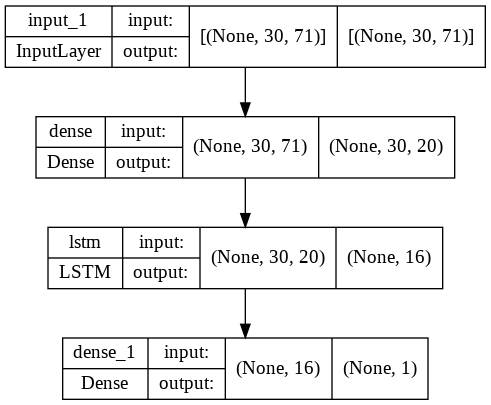

In [50]:
keras.utils.plot_model(model,show_shapes=True)

In [51]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 0.7576 - accuracy: 0.5157 - auc: 0.4968
Epoch 1: val_loss improved from inf to 0.75835, saving model to model_checkpoint.h5
23/23 [==============================] - 4s 76ms/step - loss: 0.7576 - accuracy: 0.5157 - auc: 0.4968 - val_loss: 0.7583 - val_accuracy: 0.5182 - val_auc: 0.4991
Epoch 2/10
22/23 [===========================>..] - ETA: 0s - loss: 0.7293 - accuracy: 0.5142 - auc: 0.5003
Epoch 2: val_loss improved from 0.75835 to 0.71030, saving model to model_checkpoint.h5
23/23 [==============================] - 1s 51ms/step - loss: 0.7284 - accuracy: 0.5157 - auc: 0.4974 - val_loss: 0.7103 - val_accuracy: 0.5182 - val_auc: 0.5009
Epoch 3/10
22/23 [===========================>..] - ETA: 0s - loss: 0.7093 - accuracy: 0.5142 - auc: 0.4979
Epoch 3: val_loss improved from 0.71030 to 0.70347, saving model to model_checkpoint.h5
23/23 [==============================] - 1s 50ms/step - loss: 0.7087 - accuracy: 0.5157 - au

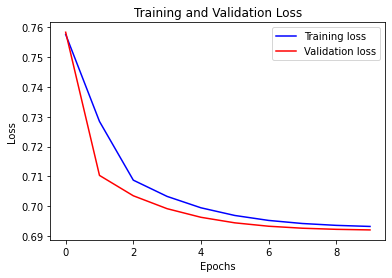

In [52]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [35]:
!pip install -q -U keras-tuner
import keras_tuner as kt

In [40]:
def model_builder(hp):
    inputs = keras.layers.Input(shape=(30, 71)) #(ts lenght, number of features)
    hp_units = hp.Int('units', min_value = 8, max_value=32, step=4)
    lstm_out = keras.layers.LSTM(units=hp_units)(inputs)
    outputs = keras.layers.Dense(1)(lstm_out)

    model = keras.Model(inputs=inputs, outputs=outputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss="mse")
    return model

In [41]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=4,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [42]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [43]:
tuner.search(dataset_train, epochs=2, validation_data=dataset_val, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first LSTM layer
layer is 20 and the optimal learning rate for the optimizer
is 0.01.



In [53]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=step,
)

inputs, targets = batch
test_loss, test_acc, test_auc = model.evaluate(inputs, targets)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test AUC:', test_auc)

8/8 [==============================] - 1s 9ms/step - loss: 0.6894 - accuracy: 0.5469 - auc: 0.5000
Test loss: 0.6894071698188782
Test accuracy: 0.546875
Test AUC: 0.5
